<a href="https://colab.research.google.com/github/coded-sly/s5e11-Loan-Payback/blob/main/Ps5e11_bartz_cv5_0_92602.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q bartz

In [ ]:
## -- Device-Agnostic for GPU --
import torch
print(f"ℹ️ Cuda available: {torch.cuda.is_available()}")

%load_ext cudf.pandas
%load_ext cuml.accel
from cuml.preprocessing import TargetEncoder as cuTE

ℹ️ Cuda available: True
The cudf.pandas extension is already loaded. To reload it, use:
  %reload_ext cudf.pandas


In [ ]:
## -- IMPORT LIBRARIES --
import sys, os, gc

## -- DATA MANIPUALATION --
import numpy as np, pandas as pd, random

## -- VISUALISATION --
from IPython.display import display, Image
import matplotlib.pyplot as plt
import seaborn as sns
import shap

## -- FUNCTIONAL TOOLS --
from time import time, sleep
from tqdm.notebook import tqdm
from itertools import combinations, product

## -- MACHINE LEARNING --
# import tabpfn
import bartz
from bartz.BART import gbart

import sklearn
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import (
                roc_auc_score, RocCurveDisplay,
                ConfusionMatrixDisplay, classification_report
)

import warnings

In [ ]:
print(f"sklearn version: {sklearn.__version__}")
print(f"bartzml version: {bartz.__version__}")

sklearn version: 1.6.1
bartzml version: 0.7.0


In [ ]:
## -- Global Settings --
# sklearn.set_config(transform_output="pandas")
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

# pd.options.mode.copy_on_write = True
pd.set_option('display.max_columns', 1000)
# plt.style.use("ggplot")
sns.set_style("darkgrid")
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)

## -- Set Global Seed --
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

COLOR = '\033[32m'
RESET = '\033[0m'

# from google.colab import data_table
# data_table.enable_dataframe_formatter()

In [ ]:
### Load Data ###
submit = pd.read_csv("sample_submission.csv")
train = pd.read_csv("/content/train.csv", index_col='id')
test = pd.read_csv("/content/test.csv", index_col='id')
orig = pd.read_csv("/content/train_20_000.csv")

TARGET = "loan_paid_back"
NUMS = test.select_dtypes(include='number').columns.tolist()
CATS = test.select_dtypes(exclude='number').columns.tolist()
BASE = NUMS + CATS

for (name, df) in dict(Train=train, Test=test, Original=orig).items():
    print(f"{name} shape: {df.shape}")

print(f"\nTotal Numerical: {len(NUMS)}")
print(f"Total Categorical: {len(CATS)}")
print(f"Total base features: {len(BASE)}")

Train shape: (593994, 12)
Test shape: (254569, 11)
Original shape: (20000, 12)

Total Numerical: 5
Total Categorical: 6
Total base features: 11


In [ ]:
# display(test.head())
train.info()

<class 'cudf.core.dataframe.DataFrame'>
Index: 593994 entries, 0 to 593993
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   annual_income         593994 non-null  float64
 1   debt_to_income_ratio  593994 non-null  float64
 2   credit_score          593994 non-null  int64
 3   loan_amount           593994 non-null  float64
 4   interest_rate         593994 non-null  float64
 5   gender                593994 non-null  object
 6   marital_status        593994 non-null  object
 7   education_level       593994 non-null  object
 8   employment_status     593994 non-null  object
 9   loan_purpose          593994 non-null  object
 10  grade_subgrade        593994 non-null  object
 11  loan_paid_back        593994 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 70.4+ MB


In [ ]:
train.head()

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
id,,,,,,,,,,,,
0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


In [ ]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
annual_income,593994.0,48212.202976,26711.942078,6002.430,27934.400,46557.680,60981.320,393381.740
debt_to_income_ratio,593994.0,0.120696,0.068573,0.011,0.072,0.096,0.156,0.627
credit_score,593994.0,680.916009,55.424956,395.000,646.000,682.000,719.000,849.000
loan_amount,593994.0,15020.297629,6926.530568,500.090,10279.620,15000.220,18858.580,48959.950
interest_rate,593994.0,12.356345,2.008959,3.200,10.990,12.370,13.680,20.990
loan_paid_back,593994.0,0.798820,0.400883,0.000,1.000,1.000,1.000,1.000


In [ ]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
annual_income,254569.0,48233.080193,26719.658580,6011.770,27950.300,46528.980,61149.440,380653.940
debt_to_income_ratio,254569.0,0.120583,0.068582,0.011,0.072,0.096,0.156,0.627
credit_score,254569.0,681.037691,55.624118,395.000,646.000,683.000,719.000,849.000
loan_amount,254569.0,15016.753484,6922.165182,500.050,10248.580,15000.220,18831.460,48959.260
interest_rate,254569.0,12.352323,2.017602,3.200,10.980,12.370,13.690,21.290


In [ ]:
train.nunique(dropna=False).sort_values(ascending=False)

,0
annual_income,119728
loan_amount,111570
interest_rate,1454
debt_to_income_ratio,526
credit_score,399
grade_subgrade,30
loan_purpose,8
education_level,5
employment_status,5
marital_status,4


# FEATURE ENGINEERING

In [ ]:
## -- Factorize using combined data --
for c in tqdm([i for i in CATS if train[i].dtype == 'object']):
    combined = pd.concat([train[c], test[c], orig[c]], axis=0)
    combined = combined.factorize()[0]
    train[c] = combined[:len(train)].astype(int)
    test[c]  = combined[len(train):len(train)+len(test)].astype(int)
    orig[c]  = combined[-len(orig):].astype(int)

print('Label encoding complete!!')

  0%|          | 0/6 [00:00<?, ?it/s]

Label encoding complete!!


## ROUND - DIGITS - BINS - INTERACTIONS - ORIGINAL TE COLUMNS

In [ ]:
## -- Define categories for OHE --
CAT_COLS = [c for c in BASE if train[c].dtype=='object' or train[c].nunique() <= 0.01*len(train)]
print(f"ℹ️ Features for TE: {len(CAT_COLS)} -> {CAT_COLS}")

ℹ️ Features for TE: 9 -> ['debt_to_income_ratio', 'credit_score', 'interest_rate', 'gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade_subgrade']


In [ ]:
ROUND = []
for col in tqdm(['annual_income', 'loan_amount']):
    for r in [-2, -1, 0, 1]:
        n = f"{col}_r{r}"
        train[n] = train[col].round(r).astype(int)
        test[n] = test[col].round(r).astype(int)
        orig[n] = test[col].round(r).astype(int)
        ROUND.append(n)

print(f'{len(ROUND)} ROUND Features created.')
print(train[ROUND].nunique())

DIGITS = []
for col in tqdm(['debt_to_income_ratio']):
    for d in range(1, 4):
        n = f'{col}_d{d}'
        train[n] = ((train[col] * 10**d) % 10).fillna(-1).astype(int)
        test[n]  = ((test[col]  * 10**d) % 10).fillna(-1).astype(int)
        orig[n]  = ((orig[col]  * 10**d) % 10).fillna(-1).astype(int)

        ## -- Drop constant features --
        if train[n].nunique() < 2:
            train.drop([n], axis=1, inplace=True)
            test.drop([n],  axis=1, inplace=True)
            orig.drop([n],  axis=1, inplace=True)
        else:
            DIGITS.append(n)

for col in tqdm(['interest_rate']):
    for d in range(1, 3):
        n = f'{col}_d{d}'
        train[n] = ((train[col] * 10**d) % 10).fillna(-1).astype(int)
        test[n]  = ((test[col]  * 10**d) % 10).fillna(-1).astype(int)
        orig[n]  = ((orig[col]  * 10**d) % 10).fillna(-1).astype(int)

        ## -- Drop constant features --
        if train[n].nunique() < 2:
            train.drop([n], axis=1, inplace=True)
            test.drop([n],  axis=1, inplace=True)
            orig.drop([n],  axis=1, inplace=True)
        else:
            DIGITS.append(n)

print(f'{len(DIGITS)} Features DIGITS extracted.')
print(train[DIGITS].nunique())

INTER = []
for col1, col2 in tqdm(list(combinations(CAT_COLS+DIGITS, 2)), desc="Pairwise"):
    new_col = f"TE_{col1}-|-{col2}"
    train[new_col] = train[col1].astype(str) + '_' + train[col2].astype(str)
    test[new_col] = test[col1].astype(str) + '_' + test[col2].astype(str)
    INTER.append(new_col)

print(f"Ineraction Features: {len(INTER)}")

  0%|          | 0/2 [00:00<?, ?it/s]

8 ROUND Features created.
annual_income_r-2     1721
annual_income_r-1     9706
annual_income_r0     35523
annual_income_r1     30775
loan_amount_r-2        426
loan_amount_r-1       3558
loan_amount_r0       21644
loan_amount_r1       19266
dtype: int64


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

5 Features DIGITS extracted.
debt_to_income_ratio_d1     7
debt_to_income_ratio_d2    10
debt_to_income_ratio_d3    10
interest_rate_d1           10
interest_rate_d2           10
dtype: int64


Pairwise:   0%|          | 0/91 [00:00<?, ?it/s]

Ineraction Features: 91


In [ ]:
# ROUND = []
# for col in tqdm(['annual_income', 'loan_amount'], desc="Rounding"):
#     for r in [-2, -1, 0, 1]:
#         n = f"{col}_r{r}"
#         train[n] = train[col].round(r).astype(int)
#         test[n] = test[col].round(r).astype(int)
#         orig[n] = test[col].round(r).astype(int)
#         ROUND.append(n)

# print(f'{len(ROUND)} ROUND Features created.')
# print(train[ROUND].nunique())

BINS = []
b = 6
for c in tqdm(['loan_amount','annual_income'], desc='Binning'):
    n = f"{c}_bin{b}"
    train[n], edges = pd.cut(train[c], bins=b, duplicates='drop', retbins=True, labels=False)
    test[n] = pd.cut(test[c], bins=edges, include_lowest=True, labels=False)
    test[n].fillna(-1, inplace=True)
    BINS.append(n)

print(f"Total Binned Features: {len(BINS)}")

# INTER = []
# for col1, col2 in tqdm(list(combinations(CAT_COLS+BINS, 2)), desc="Pairwise"):#+BINS
#     new_col = f"TE_{col1}-|-{col2}"
#     train[new_col] = train[col1].astype(str) + '_' + train[col2].astype(str)
#     test[new_col] = test[col1].astype(str) + '_' + test[col2].astype(str)
#     INTER.append(new_col)
# print(f"Ineraction Features: {len(INTER)}")


Binning:   0%|          | 0/2 [00:00<?, ?it/s]

Total Binned Features: 2


In [ ]:
ORIG = []

for col in tqdm(BASE): #
    # MEAN
    mean_map = orig.groupby(col)[TARGET].mean()
    mean_col = f"OTE_{col}_mean"
    mean_map.name = mean_col

    train = train.merge(mean_map, on=col, how='left').fillna(orig[TARGET].mean())
    test = test.merge(mean_map, on=col, how='left').fillna(orig[TARGET].mean())
    ORIG.append(mean_col)

    # COUNT
    count_col = f"OTE_{col}_count"
    count_map = orig.groupby(col).size().reset_index(name=count_col)

    train = train.merge(count_map, on=col, how='left').fillna(0)
    test = test.merge(count_map, on=col, how='left').fillna(0)
    ORIG.append(count_col)

print(len(ORIG), 'Orig Features added as columns!!')

  0%|          | 0/11 [00:00<?, ?it/s]

22 Orig Features added as columns!!


In [ ]:
train.head()

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back,annual_income_r-2,annual_income_r-1,annual_income_r0,annual_income_r1,loan_amount_r-2,loan_amount_r-1,loan_amount_r0,loan_amount_r1,debt_to_income_ratio_d1,debt_to_income_ratio_d2,debt_to_income_ratio_d3,interest_rate_d1,interest_rate_d2,TE_debt_to_income_ratio-|-credit_score,TE_debt_to_income_ratio-|-interest_rate,TE_debt_to_income_ratio-|-gender,TE_debt_to_income_ratio-|-marital_status,TE_debt_to_income_ratio-|-education_level,TE_debt_to_income_ratio-|-employment_status,TE_debt_to_income_ratio-|-loan_purpose,TE_debt_to_income_ratio-|-grade_subgrade,TE_debt_to_income_ratio-|-debt_to_income_ratio_d1,TE_debt_to_income_ratio-|-debt_to_income_ratio_d2,TE_debt_to_income_ratio-|-debt_to_income_ratio_d3,TE_debt_to_income_ratio-|-interest_rate_d1,TE_debt_to_income_ratio-|-interest_rate_d2,TE_credit_score-|-interest_rate,TE_credit_score-|-gender,TE_credit_score-|-marital_status,TE_credit_score-|-education_level,TE_credit_score-|-employment_status,TE_credit_score-|-loan_purpose,TE_credit_score-|-grade_subgrade,TE_credit_score-|-debt_to_income_ratio_d1,TE_credit_score-|-debt_to_income_ratio_d2,TE_credit_score-|-debt_to_income_ratio_d3,TE_credit_score-|-interest_rate_d1,TE_credit_score-|-interest_rate_d2,TE_interest_rate-|-gender,TE_interest_rate-|-marital_status,TE_interest_rate-|-education_level,TE_interest_rate-|-employment_status,TE_interest_rate-|-loan_purpose,TE_interest_rate-|-grade_subgrade,TE_interest_rate-|-debt_to_income_ratio_d1,TE_interest_rate-|-debt_to_income_ratio_d2,TE_interest_rate-|-debt_to_income_ratio_d3,TE_interest_rate-|-interest_rate_d1,TE_interest_rate-|-interest_rate_d2,TE_gender-|-marital_status,TE_gender-|-education_level,TE_gender-|-employment_status,TE_gender-|-loan_purpose,TE_gender-|-grade_subgrade,TE_gender-|-debt_to_income_ratio_d1,TE_gender-|-debt_to_income_ratio_d2,TE_gender-|-debt_to_income_ratio_d3,TE_gender-|-interest_rate_d1,TE_gender-|-interest_rate_d2,TE_marital_status-|-education_level,TE_marital_status-|-employment_status,TE_marital_status-|-loan_purpose,TE_marital_status-|-grade_subgrade,TE_marital_status-|-debt_to_income_ratio_d1,TE_marital_status-|-debt_to_income_ratio_d2,TE_marital_status-|-debt_to_income_ratio_d3,TE_marital_status-|-interest_rate_d1,TE_marital_status-|-interest_rate_d2,TE_education_level-|-employment_status,TE_education_level-|-loan_purpose,TE_education_level-|-grade_subgrade,TE_education_level-|-debt_to_income_ratio_d1,TE_education_level-|-debt_to_income_ratio_d2,TE_education_level-|-debt_to_income_ratio_d3,TE_education_level-|-interest_rate_d1,TE_education_level-|-interest_rate_d2,TE_employment_status-|-loan_purpose,TE_employment_status-|-grade_subgrade,TE_employment_status-|-debt_to_income_ratio_d1,TE_employment_status-|-debt_to_income_ratio_d2,TE_employment_status-|-debt_to_income_ratio_d3,TE_employment_status-|-interest_rate_d1,TE_employment_status-|-interest_rate_d2,TE_loan_purpose-|-grade_subgrade,TE_loan_purpose-|-debt_to_income_ratio_d1,TE_loan_purpose-|-debt_to_income_ratio_d2,TE_loan_purpose-|-debt_to_income_ratio_d3,TE_loan_purpose-|-interest_rate_d1,TE_loan_purpose-|-interest_rate_d2,TE_grade_subgrade-|-debt_to_income_ratio_d1,TE_grade_subgrade-|-debt_to_income_ratio_d2,TE_grade_subgrade-|-debt_to_income_ratio_d3,TE_grade_subgrade-|-interest_rate_d1,TE_grade_subgrade-|-interest_rate_d2,TE_debt_to_income_ratio_d1-|-debt_to_income_ratio_d2,TE_debt_to_income_ratio_d1-|-debt_to_income_ratio_d3,TE_debt_to_income_ratio_d1-|-interest_rate_d1,TE_debt_to_income_ratio_d1-|-interest_rate_d2,TE_debt_to_income_ratio_d2-|-debt_to_income_ratio_d3,TE_debt_to_income_ratio_d2-|-interest_rate_d1,TE_debt_to_income_ratio_d2-|-interest_rate_d2,TE_debt_to_income_ratio_d3-|-interest_rate_d1,TE_debt_to_income_ratio_d3-|-interest_rate_d2,TE_interest_rate_d1-|-interest_rate_d2,loan_amount_bin6,annual_income_bin6,OTE

In [ ]:
train.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 593994 entries, 0 to 593993
Columns: 140 entries, annual_income to OTE_grade_subgrade_count
dtypes: float64(16), int64(33), object(91)
memory usage: 656.7+ MB


In [ ]:
# @title
from sklearn.base import BaseEstimator, TransformerMixin

class TargetEncoder(BaseEstimator, TransformerMixin):
    """
    Target Encoder that supports multiple aggregation functions,
    internal cross-validation for leakage prevention, and smoothing.

    Parameters
    ----------
    cols_to_encode : list of str
        List of column names to be target encoded.

    aggs : list of str, default=['mean']
        List of aggregation functions to apply. Any function accepted by
        pandas' `.agg()` method is supported, such as:
        'mean', 'std', 'var', 'min', 'max', 'skew', 'nunique',
        'count', 'sum', 'median'.
        Smoothing is applied only to the 'mean' aggregation.

    cv : int, default=5
        Number of folds for cross-validation in fit_transform.

    smooth : float or 'auto', default='auto'
        The smoothing parameter `m`. A larger value puts more weight on the
        global mean. If 'auto', an empirical Bayes estimate is used.

    drop_original : bool, default=False
        If True, the original columns to be encoded are dropped.
    """
    def __init__(self, cols_to_encode, aggs=['mean'], cv=5, smooth='auto', drop_original=False):
        self.cols_to_encode = cols_to_encode
        self.aggs = aggs
        self.cv = cv
        self.smooth = smooth
        self.drop_original = drop_original
        self.mappings_ = {}
        self.global_stats_ = {}

    def fit(self, X, y):
        """
        Learn mappings from the entire dataset.
        These mappings are used for the transform method on validation/test data.
        """
        temp_df = X.copy()
        temp_df['target'] = y

        # Learn global statistics for each aggregation
        for agg_func in self.aggs:
            self.global_stats_[agg_func] = y.agg(agg_func)

        # Learn category-specific mappings
        for col in self.cols_to_encode:
            self.mappings_[col] = {}
            for agg_func in self.aggs:
                mapping = temp_df.groupby(col)['target'].agg(agg_func)
                self.mappings_[col][agg_func] = mapping

        return self

    def transform(self, X):
        """
        Apply learned mappings to the data.
        Unseen categories are filled with global statistics.
        """
        X_transformed = X.copy()
        for col in self.cols_to_encode:
            for agg_func in self.aggs:
                new_col_name = f'TE_{col}_{agg_func}'
                map_series = self.mappings_[col][agg_func]
                X_transformed[new_col_name] = X[col].map(map_series)
                X_transformed[new_col_name].fillna(self.global_stats_[agg_func], inplace=True)

        if self.drop_original:
            X_transformed.drop(columns=self.cols_to_encode, inplace=True)

        return X_transformed

    def fit_transform(self, X, y):
        """
        Fit and transform the data using internal cross-validation to prevent leakage.
        """
        # First, fit on the entire dataset to get global mappings for transform method
        self.fit(X, y)

        # Initialize an empty DataFrame to store encoded features
        encoded_features = pd.DataFrame(index=X.index)

        kf = KFold(n_splits=self.cv, shuffle=True, random_state=42)

        for train_idx, val_idx in kf.split(X, y):
            X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
            X_val = X.iloc[val_idx]

            temp_df_train = X_train.copy()
            temp_df_train['target'] = y_train

            for col in self.cols_to_encode:
                # --- Calculate mappings only on the training part of the fold ---
                for agg_func in self.aggs:
                    new_col_name = f'TE_{col}_{agg_func}'

                    # Calculate global stat for this fold
                    fold_global_stat = y_train.agg(agg_func)

                    # Calculate category stats for this fold
                    mapping = temp_df_train.groupby(col)['target'].agg(agg_func)

                    # --- Apply smoothing only for 'mean' aggregation ---
                    if agg_func == 'mean':
                        counts = temp_df_train.groupby(col)['target'].count()

                        m = self.smooth
                        if self.smooth == 'auto':
                            # Empirical Bayes smoothing
                            variance_between = mapping.var()
                            avg_variance_within = temp_df_train.groupby(col)['target'].var().mean()
                            if variance_between > 0:
                                m = avg_variance_within / variance_between
                            else:
                                m = 0  # No smoothing if no variance between groups

                        # Apply smoothing formula
                        smoothed_mapping = (counts * mapping + m * fold_global_stat) / (counts + m)
                        encoded_values = X_val[col].map(smoothed_mapping)
                    else:
                        encoded_values = X_val[col].map(mapping)

                    # Store encoded values for the validation fold
                    encoded_features.loc[X_val.index, new_col_name] = encoded_values.fillna(fold_global_stat)

        # Merge with original DataFrame
        X_transformed = X.copy()
        for col in encoded_features.columns:
            X_transformed[col] = encoded_features[col]

        if self.drop_original:
            X_transformed.drop(columns=self.cols_to_encode, inplace=True)

        return X_transformed

In [ ]:
FEATURES = [c for c in train.columns if c != TARGET]
print('Total Features', len(FEATURES))

Total Features 139


# ML TRAINING

The `gbart()` function, likely an implementation of Bayesian Additive Regression Trees (BART), has several parameters that control the behavior and performance of the model. Here's a breakdown of the parameters seen in your code and how they can be tuned:

### `ntree` (Number of Trees)

*   **Description**: This parameter specifies the number of trees in the BART ensemble. BART models build an ensemble of shallow trees to make predictions.
*   **Performance Impact**:
    *   **Higher `ntree`**: Generally leads to more stable predictions and potentially better accuracy, as the model has more individual trees to learn from and average. It can help reduce variance.
    *   **Lower `ntree`**: May result in a simpler model, faster training, but potentially lower accuracy and higher bias.
*   **Optimal Values**: The value of 1000 is a common starting point. You can experiment with values like `50`, `100`, `200`, `500`, `1000`, `2000`, or even `5000`. The optimal `ntree` often depends on the dataset size and complexity. For most tasks, `200` to `1000` is a good range, but for very complex relationships, you might go higher. There are diminishing returns, so excessively large numbers might only increase training time without significant accuracy gains.

### `k` (Regularization Parameter)

*   **Description**: `k` controls the strength of the regularization prior on the tree's terminal node parameters. A larger `k` means weaker regularization, allowing individual trees to fit the data more closely. A smaller `k` means stronger regularization, forcing the trees to be simpler.
*   **Performance Impact**:
    *   **Larger `k`**: Allows for more complex trees and a potentially better fit to the training data, but increases the risk of overfitting.
    *   **Smaller `k`**: Encourages simpler trees and reduces overfitting, but might lead to underfitting if too small.
*   **Optimal Values**: The default is often `2` or `3` (as seen in your code). Common values range from `1` to `5`. This is a crucial parameter for balancing bias and variance. `3.0` is a reasonable starting value. Cross-validation is often used to find the best `k` for a given dataset.

### `maxdepth` (Maximum Tree Depth)

*   **Description**: This parameter (commented out in your code) limits the maximum depth of each individual tree in the ensemble. BART typically uses shallow trees.
*   **Performance Impact**:
    *   **Larger `maxdepth`**: Allows trees to capture more complex interactions, but increases the risk of overfitting and computational cost.
    *   **Smaller `maxdepth`**: Promotes simpler trees, reducing overfitting, but might limit the model's ability to capture complex patterns. BART's power comes from many shallow trees, not deep ones.
*   **Optimal Values**: Typical values for BART are relatively small, often between `2` and `6`. `6` (as seen in the commented code) is a good upper bound. You might start with `2` or `3` and increase if the model underfits.

### `sigdf` (Degrees of Freedom for Inverse Chi-Squared Prior on $\sigma^2$)

*   **Description**: This parameter (commented out in your code) relates to the prior distribution for the error variance ($\\sigma^2$). It's the degrees of freedom for the inverse chi-squared prior. It helps regularize the estimate of the error variance.
*   **Performance Impact**: Affects how uncertain the model is about its predictions. Incorrect `sigdf` can lead to under- or over-estimated uncertainty, which impacts the model's confidence and potentially its ability to generalize.
*   **Optimal Values**: `3.0` (as seen in the commented code) is a standard choice, providing a relatively non-informative prior. Values typically range from `3` to `10`. Generally, it's not a parameter that needs extensive tuning unless you have strong prior beliefs about the noise level in your data.

### `sigquant` (Quantile for Error Variance)

*   **Description**: This parameter (commented out in your code) specifies the quantile of the error variance ($\\sigma^2$) that the BART model targets during initialization. Specifically, it helps set the scale of the prior for $\\sigma^2$.
*   **Performance Impact**: Similar to `sigdf`, it influences the prior on the error variance. If set inappropriately, it can lead to under- or over-estimation of the true noise, affecting prediction intervals and overall model fit.
*   **Optimal Values**: A common value is `0.9` or `0.95`, meaning the model assumes that the true $\\sigma^2$ is below the $90^{th}$ or $95^{th}$ percentile of the prior. `0.9` (as seen in the commented code) is a sensible default. It's often paired with `sigdf`.

### `ndpost` (Number of Posterior Samples to Keep)

*   **Description**: This parameter (commented out in your code) determines the number of posterior samples (trees) to retain after the `nskip` burn-in period. These samples are used for predictions and uncertainty quantification.
*   **Performance Impact**:
    *   **Larger `ndpost`**: Provides a more accurate estimate of the posterior distribution and more stable predictions, reducing Monte Carlo error.
    *   **Smaller `ndpost`**: Can lead to less stable predictions and less accurate uncertainty estimates, but faster computation.
*   **Optimal Values**: Values like `1000`, `2000`, or `5000` are common. `1000` (as seen in the commented code) is a good starting point. You might increase it if your results are too variable between runs or if you need more precise credible intervals.

### `nskip` (Number of Burn-in Samples)

*   **Description**: This parameter specifies the number of initial MCMC (Markov Chain Monte Carlo) iterations to discard before collecting posterior samples. This burn-in period allows the chain to converge to the stationary distribution.
*   **Performance Impact**: Insufficient burn-in can lead to biased posterior estimates. Too much burn-in wastes computational resources.
*   **Optimal Values**: `nskip=200` is used in your code. Common values range from `100` to `1000`. You can assess convergence using trace plots, but `200` to `500` is often sufficient for many problems.

### `printevery` (Print Progress Frequency)

*   **Description**: This parameter controls how often the model prints progress updates during training.
*   **Performance Impact**: Does not affect model performance, only the verbosity of the output during training.
*   **Optimal Values**: Any value that gives you useful progress feedback without flooding the console. `200` is a good balance.

### `seed` (Random Seed)

*   **Description**: Sets the random seed for reproducibility of the results.
*   **Performance Impact**: Does not affect intrinsic model performance, but ensures that if you run the model multiple times with the same data and parameters, you get the exact same results.
*   **Optimal Values**: Any integer. `42` is a common choice.

### `keepevery` (Thinning Interval)

*   **Description**: This parameter specifies the thinning interval for collecting posterior samples. For example, if `keepevery=2`, only every second sample after burn-in is kept.
*   **Performance Impact**: Thinning reduces autocorrelation in the MCMC samples, which can improve the efficiency of posterior estimates. However, it also means fewer samples are used from the same number of iterations.
*   **Optimal Values**: Values like `1`, `2`, or `5` are common. `2` is used in your code. A value of `1` means no thinning. Higher values can be used if autocorrelation is very high, but generally, `1` or `2` is fine, especially with a sufficiently large `ndpost`.

### General Advice for Tuning:

*   **Cross-Validation**: The most robust way to find optimal parameter values is through cross-validation. This involves splitting your training data into multiple folds and evaluating model performance on unseen data for different parameter combinations.
*   **Iterative Tuning**: Start with reasonable default values (like those in your current `params` dict) and then iteratively tune one or two parameters at a time, observing their impact on validation performance.
*   **Focus on `ntree` and `k`**: These are often the most impactful parameters for BART's predictive performance.
*   **Computational Cost**: Be mindful that increasing `ntree`, `maxdepth`, or `ndpost` can significantly increase training and prediction times. Balancing performance with computational resources is key.

In [ ]:
## -- Define Training Parameters --
if torch.cuda.is_available():
    print(f"ℹ️ Device GPU: {torch.cuda.get_device_name(0)}")
    print(f"ℹ️ No. of CPU: {os.cpu_count()} cores")
else:
    print(f"ℹ️ Device: CPU {os.cpu_count()} cores")
## -----------------------------------------------------------------
X = train[FEATURES]
y = train[TARGET]

FOLDS = 5
kf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)

models = []
oof_preds  = np.zeros(len(X))
test_preds = np.zeros(len(test))
fold_scores = []

params = dict(
    maxdepth= 6,
    ntree= 400,
    k= 3.0,
    sigdf= 3.0,
    sigquant= 0.9,
    ndpost= 1000,
    nskip= 200,
    printevery= 200,
    seed= SEED,
    keepevery= 2,
)

tik = time()
for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print('|', '-'*20)
    print(f"Fold {fold+1}/{FOLDS}")
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    X_test = test[FEATURES].copy()

    # Opt1. -> Using CUSTOM
    # TE = TargetEncoder(cols_to_encode=INTER+ROUND,cv=5,smooth=1.0,aggs=['mean'],drop_original=True)
    # X_train = TE.fit_transform(X_train, y_train)
    # X_val   = TE.transform(X_val)
    # X_test  = TE.transform(X_test)

    # Opt2. -> Using RAPIDS
    for c in INTER+ROUND: #
        TE = cuTE(n_folds=5, smooth=1.0, stat='mean', split_method='random', seed=SEED)
        X_train[c] = TE.fit_transform(X_train[c], y_train)
        X_val[c] = TE.transform(X_val[c])
        X_test[c] = TE.transform(X_test[c])

    for c in CATS+DIGITS+BINS: #
        X_train[c] = X_train[c].astype('category')
        X_val[c]   = pd.Categorical(X_val[c], categories=X_train[c].cat.categories)
        X_test[c]  = pd.Categorical(X_test[c], categories=X_train[c].cat.categories)

    model = gbart(
        X_train.to_numpy().T,
        y_train.to_numpy(),
        **params,
    )

    y_pred = model.predict(X_val.to_numpy().T).mean(axis=0)
    oof_preds[val_idx] = y_pred

    predictions = model.predict(X_test.to_numpy().T).mean(axis=0)
    test_preds += predictions / FOLDS

    score = roc_auc_score(y_val, y_pred)
    fold_scores.append(score)
    models.append(model)

    print(f"{COLOR}\tAUC: {score:.6f}{RESET}")
    gc.collect(); sleep(2)

tok = time()
tiktok = (tok-tik) / 60
print('-'*20)
print(f"\tTraining Time: {tiktok:.2f} mins{RESET}")

ℹ️ Device GPU: Tesla T4
ℹ️ No. of CPU: 2 cores
| --------------------
Fold 1/5
........................................................................................................................................................................................................
It 200/4200 grow P=51% A=30%, prune P=49% A=32%, fill=8% (burnin)
........................................................................................................................................................................................................
It 400/4200 grow P=50% A=30%, prune P=50% A=30%, fill=8%
........................................................................................................................................................................................................
It 600/4200 grow P=53% A=28%, prune P=47% A=33%, fill=7%
..........................................................................................................................................

In [ ]:
## -- After all folds --
print(f"|{'-'*33}")
overall_AUC = roc_auc_score(y, oof_preds)
print(f"| Overall AUC: {overall_AUC:.6f}")
print(f"| Average AUC: {np.mean(fold_scores):.6f} ± {np.std(fold_scores):.6f}")

print(f"|{'-'*33}")
pred_labels = (oof_preds >= 0.5).astype(int)
print(classification_report(y, pred_labels))

|---------------------------------
| Overall AUC: 0.925617
| Average AUC: 0.925622 ± 0.000740
|---------------------------------
              precision    recall  f1-score   support

         0.0       0.87      0.64      0.74    119500
         1.0       0.92      0.98      0.95    474494

    accuracy                           0.91    593994
   macro avg       0.90      0.81      0.84    593994
weighted avg       0.91      0.91      0.90    593994



In [ ]:
X_train.shape

(475196, 139)

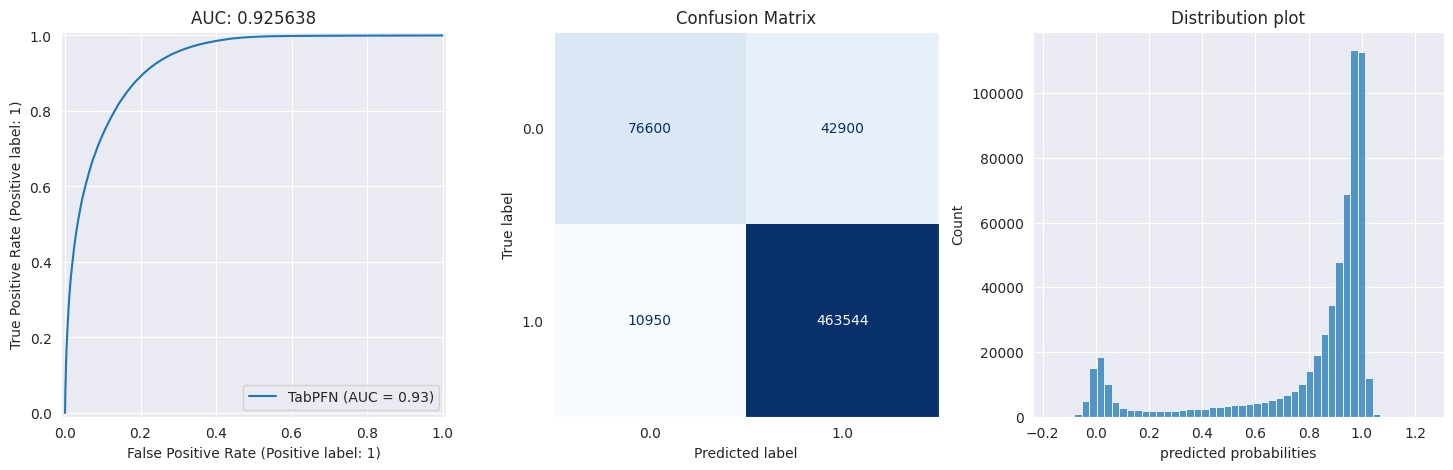

In [ ]:
_, axs = plt.subplots(1, 3, figsize=(18, 5))
## -- ROC curve --
RocCurveDisplay.from_predictions(y, oof_preds, name='TabPFN', ax=axs[0])
axs[0].set_title(f"AUC: {overall_AUC:.6f}")

## -- Confusion matrix (threshold = 0.5) --
ConfusionMatrixDisplay.from_predictions(y, pred_labels, cmap='Blues', colorbar=False, ax=axs[1])
axs[1].set_title(f"Confusion Matrix")
axs[1].grid(False)

## -- Distribution plot --
sns.histplot(oof_preds, bins=50, ax=axs[2])
axs[2].set_title(f"Distribution plot")
axs[2].set_xlabel(f"predicted probabilities")

# ## -- Plot feature importances --
# _, ax = plt.subplots(1, 1, figsize=(18, 10))
# lgb.plot_importance(models[0], max_num_features=30, height=0.5, ax=ax)

plt.show()

In [ ]:
s = str(overall_AUC).split('.')[1][:6]
np.save(f"oof_bartz_{s}.npy", oof_preds)
np.save(f"pred_bartz_{s}.npy", test_preds)
print(f"✅ oof & prediction files saved!")

submit[TARGET] = test_preds
submit.to_csv(f"submit_bartz_{s}.csv", index=False)

print(f"✅ submit_TabPFN_{s}.csv file saved!")

✅ oof & prediction files saved!
✅ submit_TabPFN_925839.csv file saved!
